In [2]:
## Imports
import re 
import numpy as np 
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Input, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.models import Model

In [3]:
## Data Paths
train_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')

In [4]:
## Preprocessing
size = train_df.shape[0]
train, validate = int(0.8*size), int(0.2*size)
validate_df = train_df.tail(validate).copy()
train_df = train_df.head(train).copy()
print(train_df.shape, validate_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

train_df['num_words'] = train_df['full_text'].apply(lambda x: len(x.split()))
avg_words = round(train_df['num_words'].mean())
max_words = round(train_df['num_words'].max())

train_df['full_text'] = train_df["full_text"].replace(re.compile(r'[\n\r\t\f\v]'), '', regex=True)
test_df['full_text'] = test_df["full_text"].replace(re.compile(r'[\n\r\t\f\v]'), '', regex=True)
validate_df['full_text'] = validate_df["full_text"].replace(re.compile(r'[\n\r\t\f\v]'), '', regex=True)

(3128, 8) (782, 8)


In [5]:
tokenizer = Tokenizer(oov_token="<NaN>")
tokenizer.fit_on_texts(train_df['full_text'])
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_df['full_text'])
validate_seq = tokenizer.texts_to_sequences(validate_df['full_text'])

pad_train = pad_sequences(train_seq, maxlen=max_words+1, truncating='post')
pad_validate = pad_sequences(validate_seq, maxlen=max_words+1, truncating='post')

word_idx_count = len(word_index) + 1

In [6]:
# Training data
X0 = pad_train
Y0 = [train_df['cohesion'].values, train_df['phraseology'].values]
X1 = pad_validate
Y1 = [validate_df['cohesion'].values, validate_df['phraseology'].values]

In [7]:
def MCRMSE(y_true, y_pred):
    mcrmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(mcrmse), axis=-1, keepdims=True)

In [8]:
def lstm_model():

    inputs = Input(shape=(max_words+1))

    embeddings = Embedding(word_idx_count, 256, input_length=max_words)(inputs)

    x1 = Conv1D(32, 5, padding='valid', activation='relu')(embeddings)
    x1 = BatchNormalization()(x1)
    x1 = Conv1D(16, 2, padding='valid', activation='relu')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Bidirectional(LSTM(64, return_sequences=True))(x1)
    x1 = Bidirectional(LSTM(32))(x1)
    
    x2 = Conv1D(24, 5, padding='valid', activation='relu')(embeddings)
    x2 = BatchNormalization()(x2)
    x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
    x2 = Bidirectional(LSTM(32))(x2)
    

    # Cohesion score
    output1 = Dense(96, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(x1)
    output1 = Dropout(0.4)(output1)
    output1 = Dense(72, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-3),  bias_regularizer=L2(1e-3),  activity_regularizer=L2(1e-3))(output1)
    output1 = Dropout(0.1)(output1)
    output1 = Dense(1, name='cohesion')(output1)


#     # Syntax score
#     output2 = Dense(128, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(x)
#     output2 = Dropout(0.3)(output2)
#     output2 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-3),  bias_regularizer=L2(1e-3),  activity_regularizer=L2(1e-3))(output2)
#     output2 = Dropout(0.3)(output2)
#     output2 = Dense(1, activation='relu', name='syn')(output2)


#     # Vocabulary score
#     output3 = Dense(128, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(x)
#     output3 = Dropout(0.3)(output3)
#     output3 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-3),  bias_regularizer=L2(1e-3),  activity_regularizer=L2(1e-3))(output3)
#     output3 = Dropout(0.3)(output3)
#     output3 = Dense(1, activation='relu', name='vocaby')(output3)
    

    # Phraseology score
    output4 = Dense(96, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(x2)
    output4 = Dropout(0.4)(output4)
    output4 = Dense(72, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-3),  bias_regularizer=L2(1e-3),  activity_regularizer=L2(1e-3))(output4)
    output4 = Dropout(0.1)(output4)
    output4 = Dense(1, name='phraseology')(output4)
    

#     # Grammar score
#     output5 = Dense(128, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(x)
#     output5 = Dropout(0.3)(output5)
#     output5 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', kernel_regularizer=L1L2(l1=1e-5, l2=1e-3),  bias_regularizer=L2(1e-3),  activity_regularizer=L2(1e-3))(output5)
#     output5 = Dropout(0.3)(output5)
#     output5 = Dense(1, activation='relu', name='gram')(output5)  
    

#     # Conventions score
#     output6 = Dense(128, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros',kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(x)
#     output6 = Dropout(0.3)(output6)
#     output6 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros',kernel_regularizer=L1L2(l1=1e-5, l2=1e-3), bias_regularizer=L2(1e-3), activity_regularizer=L2(1e-3))(output6)
#     output6 = Dropout(0.3)(output6)
#     output6 = Dense(1, activation='relu', name='conv')(output6)
    

#     model = Model(inputs=inputs, outputs=[output1, output2, output3, output4, output5, output6])
    model = Model(inputs=inputs, outputs=[output1, output4])

    model.compile(
        optimizer=Adam(learning_rate=4e-6),
        loss=MCRMSE
    )
    
    return model

model = lstm_model()
model.summary()

2022-12-10 21:00:59.072087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 21:00:59.186084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 21:00:59.187164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 21:00:59.189090: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1261)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1261, 256)    5211904     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1257, 32)     40992       embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1257, 32)     128         conv1d[0][0]                     
______________________________________________________________________________________________

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience=2, restore_best_weights=True)
history = model.fit(X0, Y0, epochs=10, batch_size=12, shuffle=True, verbose=1, validation_data=(X1, Y1), callbacks=[callback])

Epoch 1/10


2022-12-10 21:01:04.181257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-10 21:01:15.355311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 105s 333ms/step - loss: 6.1177 - cohesion_loss: 3.0531 - phraseology_loss: 2.8622 - val_loss: 6.2245 - val_cohesion_loss: 3.0811 - val_phraseology_loss: 2.9421
Epoch 2/10
261/261 [==============================] - 85s 325ms/step - loss: 5.3396 - cohesion_loss: 2.6958 - phraseology_loss: 2.4395 - val_loss: 5.1815 - val_cohesion_loss: 2.6603 - val_phraseology_loss: 2.3183
Epoch 3/10
261/261 [==============================] - 85s 325ms/step - loss: 4.3341 - cohesion_loss: 2.2934 - phraseology_loss: 1.8311 - val_loss: 3.5053 - val_cohesion_loss: 1.9153 - val_phraseology_loss: 1.3793
Epoch 4/10
261/261 [==============================] - 85s 326ms/step - loss: 3.1306 - cohesion_loss: 1.8053 - phraseology_loss: 1.1053 - val_loss: 2.2376 - val_cohesion_loss: 1.3256 - val_phraseology_loss: 0.6918
Epoch 5/10
261/261 [==============================] - 85s 326ms/step - loss: 2.3126 - cohesion_loss: 1.2937 - phraseology_loss: 0.7879 - val_loss: 1.5864 - va

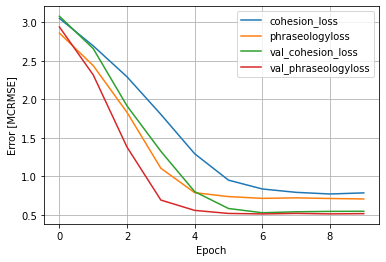

In [11]:
plt.plot(history.history['cohesion_loss'], label='cohesion_loss')
plt.plot(history.history['phraseology_loss'], label='phraseologyloss')
plt.plot(history.history['val_cohesion_loss'], label='val_cohesion_loss')
plt.plot(history.history['val_phraseology_loss'], label='val_phraseologyloss')
plt.xlabel('Epoch')
plt.ylabel('Error [MCRMSE]')
plt.legend()
plt.grid(True)

In [69]:
# Inference on test data

X_test = pad_test
results = model.predict(X_test)
lstm_submission = pd.DataFrame()
lstm_submission['text_id'] = test_df['text_id']
for i in range(6):
    lstm_submission[i] = pd.Series([float(x) for x in results[i]])
lstm_submission.columns = train_df.drop(columns=['full_text', 'num_words']).columns
lstm_submission['text_id'] = test_df['text_id']

print(lstm_submission.head())

lstm_submission.to_csv('submission.csv', index=False)

NameError: name 'pad_test' is not defined